# Install and load Hub

In [ ]:
!pip install black
!pip install blackcellmagic
%load_ext blackcellmagic

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 843 kB 38.2 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.4 which is incompatible.
     |████████████████████████████████| 156 kB 4.9 MB/s 
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attempting uninstall: black
    Found existing installation: black 22.1.0
    Uninstalling black-22.1.0:
      Successfully uninstalled black-22.1.0


In [ ]:
!pip3 install hub

     |████████████████████████████████| 287 kB 9.0 MB/s 
     |████████████████████████████████| 6.2 MB 22.9 MB/s 
     |████████████████████████████████| 132 kB 43.3 MB/s 
     |████████████████████████████████| 81 kB 9.5 MB/s 
     |████████████████████████████████| 8.6 MB 27.6 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 138 kB 42.9 MB/s 
     |████████████████████████████████| 65 kB 776 kB/s 
     |████████████████████████████████| 127 kB 10.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
%%black
import matplotlib.pyplot as plt

In [ ]:
%%black
import hub
from PIL import Image
import numpy as np
import numpy as np
import pandas as pd
import random
import os, time
import torch
from torchvision import datasets, transforms, models

ds_train = hub.load('hub://activeloop/fashion-mnist-train')
ds_test = hub.load('hub://activeloop/fashion-mnist-test')

NumExpr defaulting to 2 threads.
Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/fashion-mnist-train loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/fashion-mnist-train.
Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/fashion-mnist-test loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/fashion-mnist-test.


# Load and visualise data using the link in the output
Train data

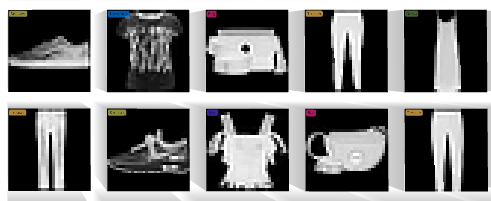

Test data(no labels)

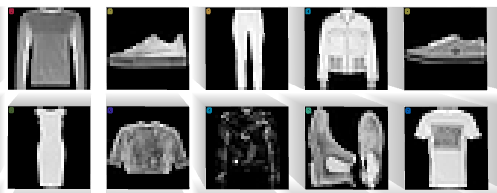


In [ ]:
%%black
ds_train = hub.load('hub://activeloop/fashion-mnist-train')
ds_test = hub.load('hub://activeloop/fashion-mnist-test')

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/fashion-mnist-train loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/fashion-mnist-train.
Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/fashion-mnist-test loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/fashion-mnist-test.


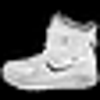

In [ ]:
%%black
Image.fromarray(ds_train.images[0].numpy()).resize((100,100))

# Data Transformation

In [ ]:
%%black
def transform(sample_in):
    return {'images': tform(sample_in['images']), 'labels': sample_in['labels']}

tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    transforms.RandomRotation(20), # Image augmentation
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.5], [0.5]),
])


# List the Batch size w.r.t data

In [ ]:
%%black
batch_size = 32

train_loader = ds_train.pytorch(num_workers = 2, shuffle = True, transform = transform, batch_size = batch_size)
test_loader = ds_test.pytorch(num_workers = 2, transform = transform, batch_size = batch_size)


In [ ]:
%%black
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")


# Model define

In [ ]:
%%black
# Simple model can be trained on a CPU
device = torch.device("cpu")

net = models.resnet18(pretrained=True)
# Convert model to grayscale
net.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Update the fully connected layer based on the number of classes in the dataset
net.fc = torch.nn.Linear(net.fc.in_features, len(ds_train.labels.info.class_names))

classifier=net.to(device)

# Specity the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.1)

# Model Training

In [ ]:
%%black
def train_model(loader, test_loader, model, epochs = 1):
    for epoch in range(epochs):  # loop over the dataset multiple times

        # Zero the performance stats for each epoch
        running_loss = 0.0
        start_time = time.time()
        total = 0
        correct = 0
        
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
        
            # Print performance statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 10 batches
                batch_time = time.time()
                speed = (i+1)/(batch_time-start_time)
                print('[%d, %5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                      (epoch + 1, i, running_loss, speed, accuracy))

                running_loss = 0.0
            plt.plot(running_loss, speed)
            plt.plot(running_loss, accuracy)
        print('Testing Model Performance')
        test_model(test_loader, model)

    print('Finished Training')
    return accuracy, running_loss, speed

In [ ]:
%%black
def test_model(loader, model):
    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))
        plt.plot(accuracy)

# Calculate Loss, Speed and Accuracy for epoch

In [ ]:
%%black
train_model(train_loader, test_loader, net, epochs = 1)

[1,     0] loss: 2.653, speed: 0.02, accuracy: 12.50 %


<IPython.core.display.Javascript object>

[1,    10] loss: 24.065, speed: 0.21, accuracy: 20.74 %
[1,    20] loss: 21.921, speed: 0.38, accuracy: 22.62 %
[1,    30] loss: 19.576, speed: 0.52, accuracy: 25.40 %
[1,    40] loss: 19.112, speed: 0.65, accuracy: 26.22 %
[1,    50] loss: 17.368, speed: 0.76, accuracy: 29.29 %
[1,    60] loss: 16.585, speed: 0.86, accuracy: 31.61 %
[1,    70] loss: 14.952, speed: 0.95, accuracy: 34.60 %
[1,    80] loss: 14.277, speed: 1.04, accuracy: 36.65 %
[1,    90] loss: 15.184, speed: 1.11, accuracy: 37.67 %
[1,   100] loss: 13.583, speed: 1.18, accuracy: 39.20 %
[1,   110] loss: 14.085, speed: 1.24, accuracy: 40.62 %
[1,   120] loss: 12.730, speed: 1.30, accuracy: 41.84 %
[1,   130] loss: 11.679, speed: 1.35, accuracy: 43.54 %
[1,   140] loss: 12.178, speed: 1.40, accuracy: 44.66 %
[1,   150] loss: 11.681, speed: 1.45, accuracy: 45.84 %
[1,   160] loss: 11.471, speed: 1.49, accuracy: 46.76 %
[1,   170] loss: 11.591, speed: 1.53, accuracy: 47.51 %
[1,   180] loss: 10.027, speed: 1.56, accuracy: 

(70.26666666666667, 2.70877942442894, 2.531415441602974)

<IPython.core.display.Javascript object>